Visualizar transformaciones antes de cargar a la extraccion

Imagenes con distrosion

Imagenes sin distorsion  y con padding

visualizar imagenes que tiene el cropbox incertado 

visualizacion sin distorcion 

Imagen mostrada: /media/databases/tiputini/original_db/Pictures 2017/Harpia plot cameras 2017/H6-600/100RECNX/IMG_0262.JPG


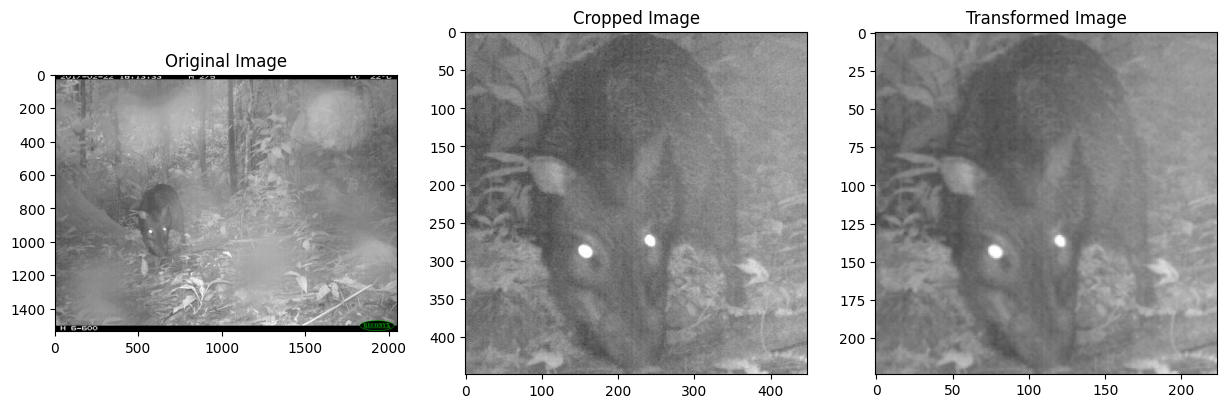

Imagen mostrada: /media/databases/tiputini/original_db/Pictures 2018/M3350/WF-33/IMG_0344.JPG


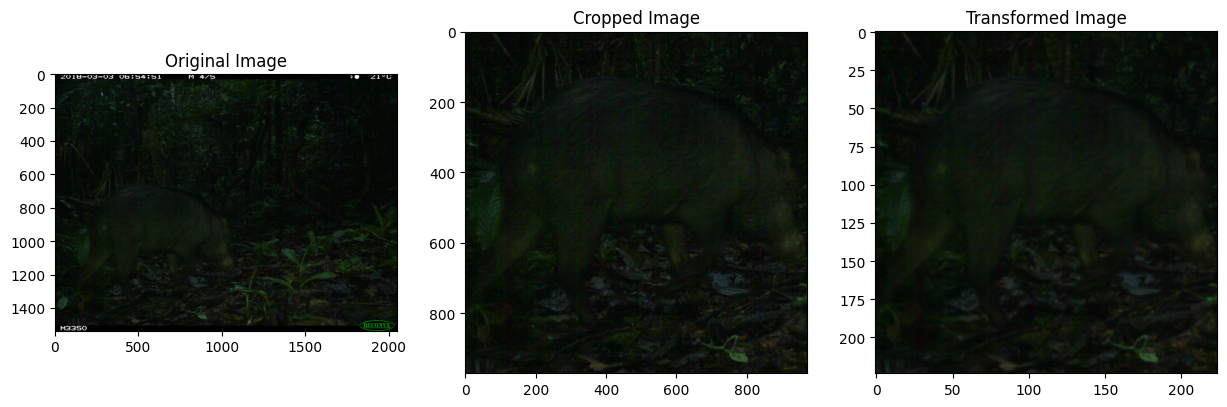

Imagen mostrada: /media/databases/tiputini/original_db/Pictures 2017/Harpia plot cameras 2017/H8-200/IMG_0024.JPG


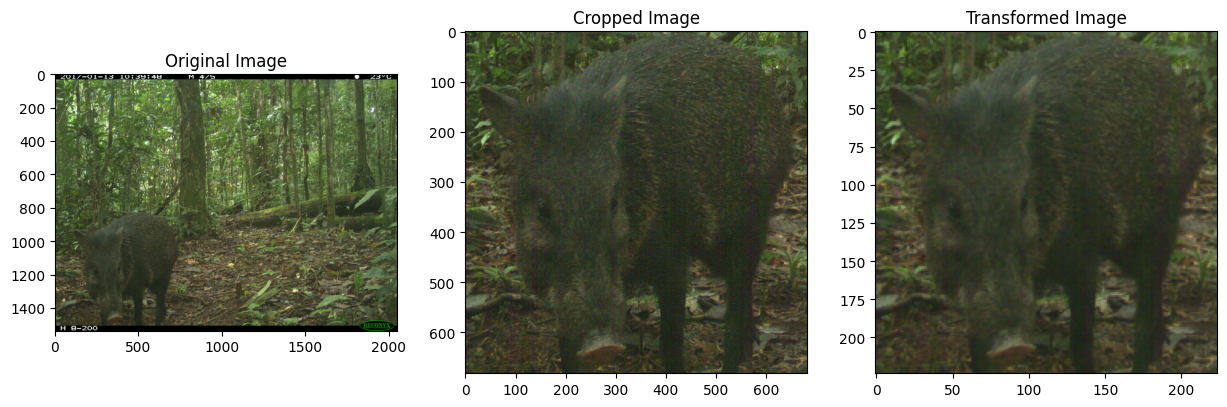

Imagen mostrada: /media/databases/tiputini/original_db/Pictures 2018/H4350/IR-69/IMG_0124.JPG


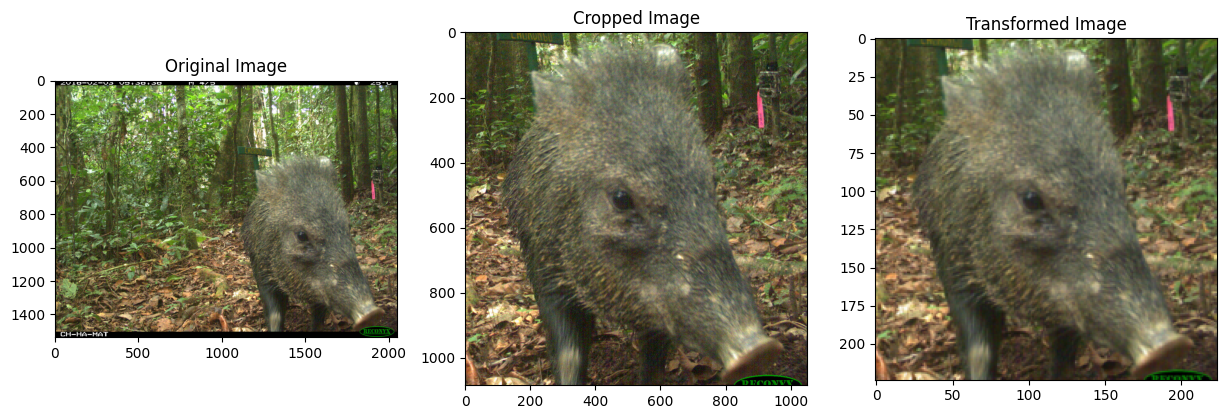

Imagen mostrada: /media/databases/tiputini/original_db/Pictures 2016/Trail Pictures 2016/M3350/IR/IMG_0102.JPG


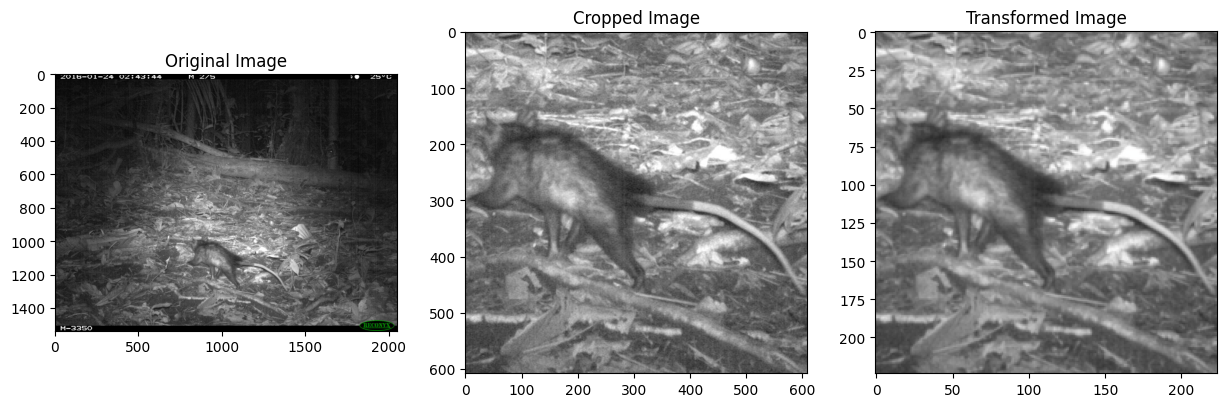

In [42]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import random

# Configuración de rutas
json_file = '/home/fbaquero/tesis/filtered_megadetector_metadata.json'
root_dir = '/media/databases/tiputini/'

# Cargar el modelo preentrenado (por ejemplo, ResNet)
model = models.resnet50(pretrained=True)
model.eval()

# Transformaciones para las imágenes
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Función para recortar la imagen usando las coordenadas del cropbox
def crop_image(image, bbox):
    left, top, right, bottom = bbox
    width = right - left
    height = bottom - top
    side_length = max(width, height)
    
    # Expandir el bounding box para que sea cuadrado, centrado en el objeto
    left = left - (side_length - width) // 2
    right = right + (side_length - width) // 2
    top = top - (side_length - height) // 2
    bottom = bottom + (side_length - height) // 2

    # Ajustar los límites para asegurarse de que están dentro de los bordes de la imagen
    left = max(left, 0)
    top = max(top, 0)
    right = min(right, image.width)
    bottom = min(bottom, image.height)

    cropped_image = image.crop((left, top, right, bottom))
    
    return cropped_image

# Leer el archivo JSON y seleccionar 10 entradas aleatorias
with open(json_file) as f:
    data = json.load(f)

random_entries = random.sample(data, min(10, len(data)))

# Mostrar 10 imágenes diferentes
images_shown = 0

for entry in random_entries:
    image_path = os.path.join(root_dir, entry['paths'][0])
    
    # Abrir la imagen original
    original_image = Image.open(image_path).convert('RGB')
    
    # Seleccionar detecciones que cumplan con los criterios
    valid_detections = []
    for detection in entry['detectors']['megadetectorV5']['output']['detections']:
        categories = detection['category']
        confidences = detection['confidence']
        bboxes = detection['bbox']
        
        for i, (category, confidence) in enumerate(zip(categories, confidences)):
            if category == 0 and confidence >= 0.9:
                valid_detections.append(bboxes[i])
    
    # Si hay detecciones válidas, mostrar la imagen recortada y transformada
    if valid_detections:
        bbox = random.choice(valid_detections)
        cropped_image = crop_image(original_image, bbox)
        
        # Mostrar la imagen original, recortada y transformada
        resized_image = preprocess(cropped_image)
        transformed_image_np = resized_image.numpy().transpose(1, 2, 0)
        
        # Deshacer la normalización para mostrar la imagen transformada correctamente
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        transformed_image_np = std * transformed_image_np + mean
        transformed_image_np = np.clip(transformed_image_np, 0, 1)
        
        # Imprimir la ruta de la imagen
        print(f"Imagen mostrada: {image_path}")
        
        # Mostrar las imágenes
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        ax[0].imshow(original_image)
        ax[0].set_title('Original Image')
        
        ax[1].imshow(cropped_image)
        ax[1].set_title('Cropped Image')
        
        ax[2].imshow(transformed_image_np)
        ax[2].set_title('Transformed Image')
        
        plt.show()
        
        images_shown += 1
        if images_shown == 22:
            break


In [2]:
import jsonlines

# Configuración de rutas
features_file = '/home/fbaquero/tesis/tesisfinal/Distorsion.jsonl'

num_elements = 0
num_features = 0

# Leer las características del archivo JSONL y obtener la longitud de las características
with jsonlines.open(features_file) as reader:
    for obj in reader:
        num_elements += 1
        for detection in obj['detectors']['megadetectorV5']['output']['detections']:
            if 'features' in detection and num_features == 0:
                feature_vector = detection['features']
                num_features = len(feature_vector)
                break

print(f"El número de elementos en el JSON es: {num_elements}")
print(f"El número de características en cada vector es: {num_features}")


El número de elementos en el JSON es: 97406
El número de características en cada vector es: 2048
